# ASL Word Training — GPU Optimized (WLASL + MediaPipe + BiLSTM)

This notebook trains a **word-level ASL model** using WLASL videos filtered by `shared_word_vocabulary.csv`.

### GPU Optimizations Applied:

- **Mixed Precision (float16)** — Faster training on modern GPUs
- **tf.data pipeline** with prefetch & shuffle — Efficient data loading
- **Memory Growth** — Prevents GPU OOM errors
- **CuDNN-compatible LSTM** — Hardware-accelerated RNN
- **Dynamic batch size** — 128 on GPU, 32 on CPU
- **L2 Regularization + He initialization** — Better generalization

### Output Artifacts:

- `asl_word_sequences.npz` — Extracted sequences
- `asl_word_lstm_model_best.h5` — Best model checkpoint
- `asl_word_lstm_model_final.h5` — Final model
- `asl_word_classes.csv` — Class mapping

### How to Run:

1. Run cells **in order** from top to bottom
2. Cell 1: Imports → Cell 2: GPU Setup → Cell 3: Config → ...
3. Set `RUN_DOWNLOAD = True` in Cell 5 if you need to download WLASL videos
4. If you already have `asl_word_sequences.npz`, skip Cells 5-6
5. Monitor GPU with `nvidia-smi -l 1` in a separate terminal


In [ ]:
# ===============================
# CELL 1: IMPORTS
# ===============================
# All required libraries for the pipeline

import json
import os
import subprocess
import time
from pathlib import Path

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.10.0
إصدار TensorFlow: 2.10.0


## Section 2: GPU Detection and Configuration

Automatic GPU detection, memory growth, and mixed precision training.  
**If you get 'Out of Memory' errors** → reduce `BATCH_SIZE` to 16 or 8, or disable mixed precision.  
**Monitor GPU** → run `nvidia-smi -l 1` in a separate terminal.


In [4]:
# ============================================
# Section 2: GPU DETECTION & CONFIGURATION
# ============================================
print('=' * 60)
print('🔍 GPU DETECTION & CONFIGURATION')
print('=' * 60)
print(f'\nTensorFlow version: {tf.__version__}')
print(f'Built with CUDA  : {tf.test.is_built_with_cuda()}')

# List all physical devices
physical_devices = tf.config.list_physical_devices()
print(f'\nAll Physical Devices: {physical_devices}')

# GPU detection
gpus = tf.config.list_physical_devices('GPU')
print(f'\n🎮 GPU Devices Found: {len(gpus)}')

USE_GPU = False
DEVICE = '/CPU:0'

if gpus:
    print('\n✅ GPU IS AVAILABLE!')
    try:
        # Enable memory growth to avoid allocating all VRAM at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'   ✅ Memory growth enabled for {len(gpus)} GPU(s)')

        # Set primary GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        USE_GPU = True
        DEVICE = '/GPU:0'
        print(f'   ✅ Using GPU: {gpus[0].name}')

        # GPU details
        try:
            details = tf.config.experimental.get_device_details(gpus[0])
            if 'device_name' in details:
                print(f'   📊 Device Name       : {details["device_name"]}')
            if 'compute_capability' in details:
                print(f'   📊 Compute Capability: {details["compute_capability"]}')
        except Exception:
            pass

    except RuntimeError as e:
        print(f'   ⚠️  GPU config error: {e}')
else:
    print('\n⚠️  No GPU detected — training on CPU (will be slower)')

# Mixed precision (optional — speeds up training on GPUs with FP16 support)
# NOTE: For LSTM models, mixed precision can cause NaN gradients on some GPUs.
# If training produces NaN loss, set ENABLE_MIXED_PRECISION = False and re-run.
ENABLE_MIXED_PRECISION = False  # Safer default for LSTM; set True to experiment

if USE_GPU and ENABLE_MIXED_PRECISION:
    try:
        # FIX: Added tf.keras prefix
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f'\n⚡ Mixed precision enabled: {policy.name}')
        print('   ℹ️  Output layer will use float32 for stability')
    except Exception as e:
        print(f'\n⚠️  Mixed precision not enabled: {e}')
else:
    # FIX: Added tf.keras prefix
    tf.keras.mixed_precision.set_global_policy('float32')
    print(f'\n📐 Using float32 precision (stable for LSTM)')

# GPU verification test
if USE_GPU:
    print('\n🧪 GPU Verification Test...')
    try:
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
            c = tf.matmul(a, b)
        print(f'   ✅ GPU computation successful: {c.device}')
    except Exception as e:
        print(f'   ❌ GPU test failed: {e}')
        USE_GPU = False
        DEVICE = '/CPU:0'

print(f'\n✅ Configuration complete. Using device: {DEVICE}')
print('=' * 60)


🔍 GPU DETECTION & CONFIGURATION

TensorFlow version: 2.10.0
Built with CUDA  : True

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

🎮 GPU Devices Found: 1

✅ GPU IS AVAILABLE!
   ✅ Memory growth enabled for 1 GPU(s)
   ✅ Using GPU: /physical_device:GPU:0
   📊 Device Name       : NVIDIA GeForce MX150
   📊 Compute Capability: (6, 1)

📐 Using float32 precision (stable for LSTM)

🧪 GPU Verification Test...


   ✅ GPU computation successful: /job:localhost/replica:0/task:0/device:GPU:0

✅ Configuration complete. Using device: /GPU:0


In [ ]:
# ===============================
# CELL 3: CONFIGURATION / PATHS
# ===============================
# Update paths below if your folder structure differs.

PROJECT_ROOT = Path(r'E:/Term 9/Grad')
SLR_MAIN = PROJECT_ROOT / 'Main/Sign-Language-Recognition-System-main/SLR Main'
WORDS_ROOT = SLR_MAIN / 'Words'
SHARED_CSV = WORDS_ROOT / 'Shared/shared_word_vocabulary.csv'

WLASL_DIR = PROJECT_ROOT / 'Words dataset'
WLASL_JSON = WLASL_DIR / 'WLASL_v0.3.json'
NSLT_SPLIT = WLASL_DIR / 'nslt_2000.json'
MISSING_TXT = WLASL_DIR / 'missing.txt'

VIDEO_DIR = WORDS_ROOT / 'Datasets/WLASL_videos'
OUTPUT_DIR = WORDS_ROOT / 'ASL Word (English)'

# Sequence parameters - LSTM needs fixed-length sequences
SEQUENCE_LENGTH = 30   # frames per sample
NUM_FEATURES = 63      # 21 landmarks × 3 (x,y,z)
MAX_DOWNLOADS = None   # set to int for quick test

VIDEO_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'📂 Shared CSV: {SHARED_CSV}')
print(f'📂 WLASL JSON: {WLASL_JSON}')
print(f'📂 Video dir: {VIDEO_DIR}')
print(f'📂 Output dir: {OUTPUT_DIR}')
print(f'🎬 Sequence length: {SEQUENCE_LENGTH}')
print(f'📐 Features per frame: {NUM_FEATURES}')


📂 Shared CSV / ملف المفردات: E:\Term 9\Grad\Main\Sign-Language-Recognition-System-main\SLR Main\Words\Shared\shared_word_vocabulary.csv
📂 WLASL JSON: E:\Term 9\Grad\Words dataset\WLASL_v0.3.json
📂 Video dir / مجلد الفيديوهات: E:\Term 9\Grad\Main\Sign-Language-Recognition-System-main\SLR Main\Words\Datasets\WLASL_videos
📂 Output dir / مجلد المخرجات: E:\Term 9\Grad\Main\Sign-Language-Recognition-System-main\SLR Main\Words\ASL Word (English)
🎬 Sequence length / طول التسلسل: 30
📐 Features per frame / خصائص لكل إطار: 63


In [ ]:
# ===============================
# CELL 4: LOAD VOCAB + WLASL METADATA
# ===============================
# Loads shared vocabulary and matches WLASL video instances to word IDs.

vocab_df = pd.read_csv(SHARED_CSV)
vocab_df = vocab_df.dropna(subset=['wlasl_class'])
vocab_df['wlasl_class'] = vocab_df['wlasl_class'].astype(int)

matched_wlasl_classes = set(vocab_df['wlasl_class'].tolist())
wlasl_to_wordid = dict(zip(vocab_df['wlasl_class'], vocab_df['word_id']))

with open(NSLT_SPLIT, 'r', encoding='utf-8') as f:
    nslt = json.load(f)

with open(MISSING_TXT, 'r', encoding='utf-8') as f:
    missing_ids = set(x.strip() for x in f if x.strip())

with open(WLASL_JSON, 'r', encoding='utf-8') as f:
    wlasl_data = json.load(f)

# Build download list filtered by shared vocabulary
download_list = []
for entry in wlasl_data:
    gloss = entry.get('gloss', '')
    for inst in entry.get('instances', []):
        vid = inst.get('video_id')
        if not vid or vid not in nslt or vid in missing_ids:
            continue
        class_id = int(nslt[vid]['action'][0])
        if class_id not in matched_wlasl_classes:
            continue
        download_list.append({
            'video_id': vid,
            'url': inst.get('url'),
            'class_id': class_id,
            'word_id': int(wlasl_to_wordid[class_id]),
            'gloss': gloss,
            'subset': nslt[vid]['subset']
        })

if MAX_DOWNLOADS:
    download_list = download_list[:MAX_DOWNLOADS]

print(f'📥 Download candidates: {len(download_list)}')
print(f'🏷️ Unique matched WLASL classes: {len(set(d["class_id"] for d in download_list))}')


📥 Download candidates / مرشحات التحميل: 1085
🏷️ Unique matched WLASL classes / فئات WLASL المطابقة: 157


In [ ]:
# ===============================
# CELL 5: OPTIONAL VIDEO DOWNLOAD
# ===============================
# Set RUN_DOWNLOAD = True to download WLASL videos.
# Skip this cell if videos already exist in VIDEO_DIR.

def try_download(url, out_path):
    """Try direct download first, then fall back to yt-dlp."""
    try:
        if url and (url.endswith('.mp4') or url.endswith('.mov')):
            r = requests.get(url, timeout=15)
            if r.status_code == 200 and len(r.content) > 1000:
                with open(out_path, 'wb') as f:
                    f.write(r.content)
                return True
    except Exception:
        pass

    try:
        result = subprocess.run(
            ['yt-dlp', '-o', str(out_path), '-f', 'best[ext=mp4]', '--quiet', url],
            capture_output=True, timeout=40
        )
        return result.returncode == 0 and out_path.exists()
    except Exception:
        return False

RUN_DOWNLOAD = False  # ← Set True when ready

if RUN_DOWNLOAD:
    ok, fail = 0, 0
    start_time = time.time()
    for item in tqdm(download_list, desc='Downloading'):
        out = VIDEO_DIR / f"{item['video_id']}.mp4"
        if out.exists():
            ok += 1
            continue
        status = try_download(item['url'], out)
        ok += int(status)
        fail += int(not status)
    duration = time.time() - start_time
    print(f'✅ Downloaded: {ok} | ❌ Failed: {fail} | ⏱️ Time: {duration:.1f}s')
else:
    existing = len(list(VIDEO_DIR.glob('*.mp4'))) if VIDEO_DIR.exists() else 0
    print(f'⏩ RUN_DOWNLOAD=False (skipped)')
    print(f'📁 Existing videos: {existing}')


⏩ RUN_DOWNLOAD=False (skipped) / تم التخطّي
📁 Existing videos / فيديوهات موجودة: 11980


In [ ]:
# ===============================
# CELL 6: EXTRACT MEDIAPIPE SEQUENCES
# ===============================
# Extracts hand landmarks from each video frame using MediaPipe.
# Skip this cell if asl_word_sequences.npz already exists!

NPZ_PATH = OUTPUT_DIR / 'asl_word_sequences.npz'

if NPZ_PATH.exists():
    print(f'⏩ Dataset already exists, skipping extraction')
    data = np.load(NPZ_PATH)
    print(f'   X: {data["X"].shape}, y: {data["y"].shape}, classes: {len(np.unique(data["y"]))}')
else:
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    def extract_video_landmarks(video_path, max_frames=SEQUENCE_LENGTH):
        """Extract hand landmarks from video, normalized to fixed length."""
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            return None

        rows = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            if results.multi_hand_landmarks:
                lm = results.multi_hand_landmarks[0]
                vec = np.array([[p.x, p.y, p.z] for p in lm.landmark]).flatten()
            else:
                vec = np.zeros(NUM_FEATURES, dtype=np.float32)
            rows.append(vec)

        cap.release()
        if len(rows) == 0:
            return None

        arr = np.array(rows, dtype=np.float32)
        if len(arr) >= max_frames:
            idx = np.linspace(0, len(arr) - 1, max_frames, dtype=int)
            arr = arr[idx]
        else:
            pad = np.zeros((max_frames - len(arr), NUM_FEATURES), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)
        return arr

    meta_by_id = {d['video_id']: d for d in download_list}
    video_files = list(VIDEO_DIR.glob('*.mp4'))

    X, y, keep_meta = [], [], []
    start_time = time.time()

    for vf in tqdm(video_files, desc='Extracting landmarks'):
        vid = vf.stem
        if vid not in meta_by_id:
            continue
        seq = extract_video_landmarks(vf)
        if seq is None:
            continue
        X.append(seq)
        y.append(meta_by_id[vid]['word_id'])
        keep_meta.append(meta_by_id[vid])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    duration = time.time() - start_time

    print(f'\n📊 X shape: {X.shape} | y shape: {y.shape} | classes: {len(np.unique(y))}')
    print(f'⏱️ Extraction time: {duration:.2f}s')

    np.savez_compressed(NPZ_PATH, X=X, y=y)
    print(f'💾 Saved: {NPZ_PATH}')


Extracting landmarks / استخراج النقاط: 100%|██████████| 11980/11980 [43:36<00:00,  4.58it/s]  



📊 X shape: (1085, 30, 63) | y shape: (1085,) | classes: 157
⏱️ Extraction time / وقت الاستخراج: 2616.33s
💾 Saved / تم الحفظ: E:\Term 9\Grad\Main\Sign-Language-Recognition-System-main\SLR Main\Words\ASL Word (English)\asl_word_sequences.npz


📊 DATA EXPLORATION / استكشاف البيانات


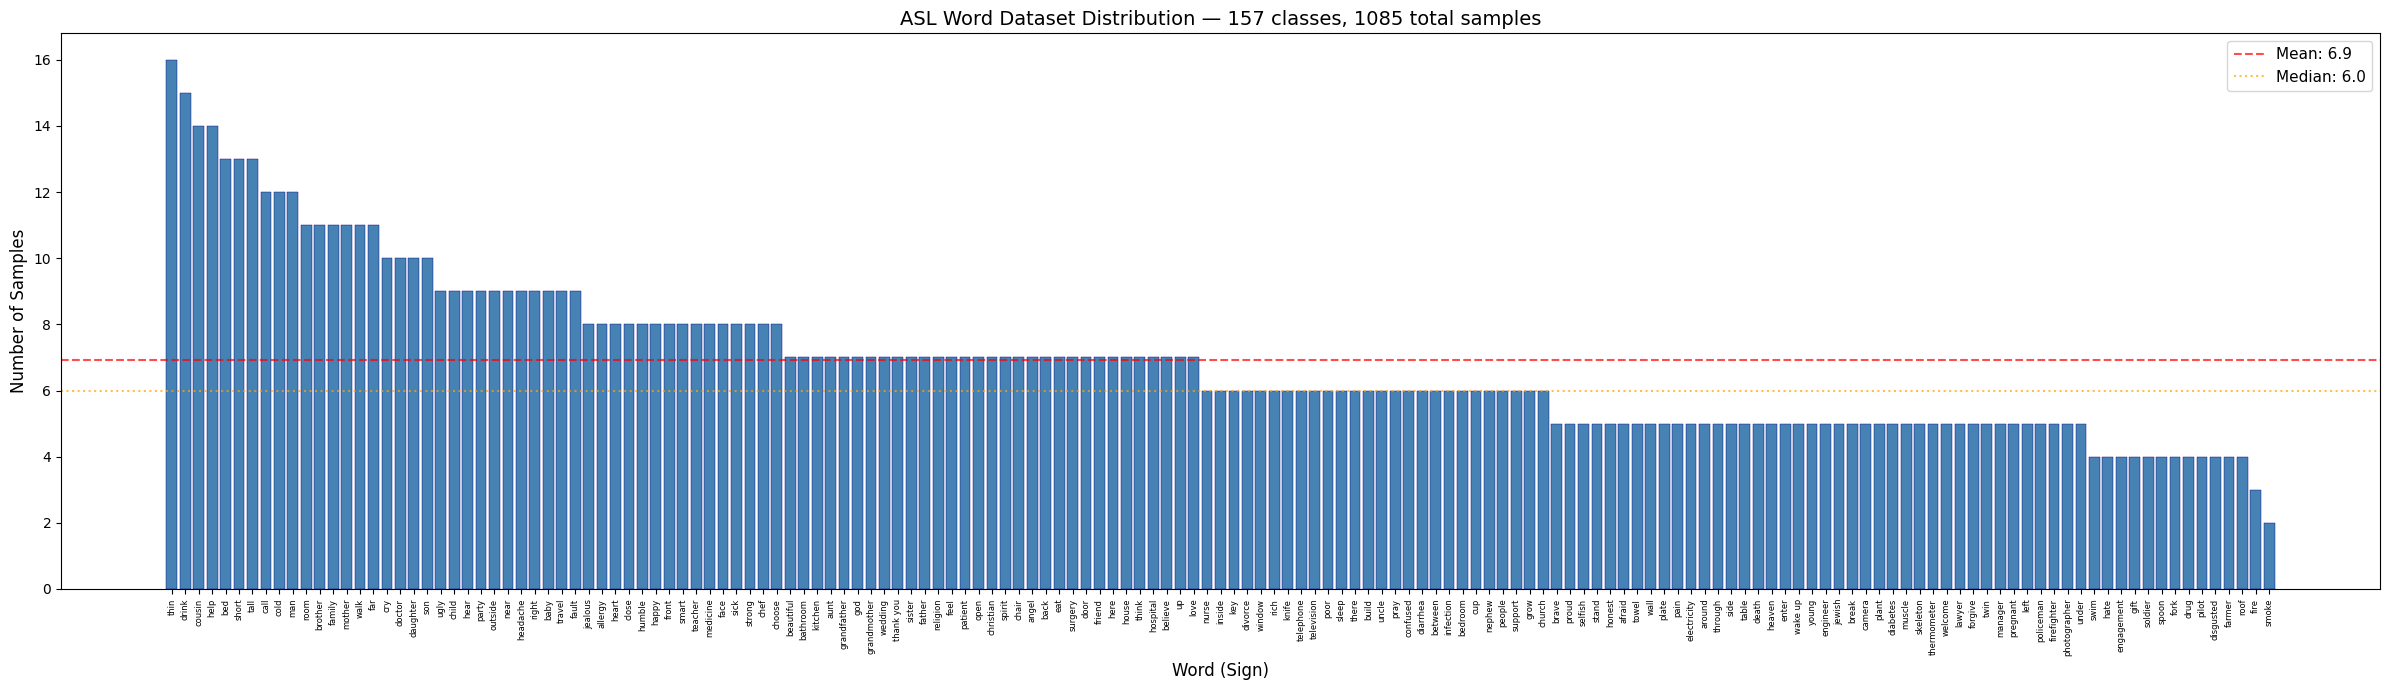


📊 Dataset Summary:
   Total samples    : 1085
   Total classes    : 157
   Min samples/class: 2 (smoke)
   Max samples/class: 16 (thin)
   Mean             : 6.9
   Std              : 2.5
   Median           : 6.0

⚠️  Classes with <5 samples (14):
   hate: 4
   fire: 3
   smoke: 2
   swim: 4
   pilot: 4
   farmer: 4
   disgusted: 4
   spoon: 4
   fork: 4
   roof: 4
   drug: 4
   soldier: 4
   gift: 4
   engagement: 4


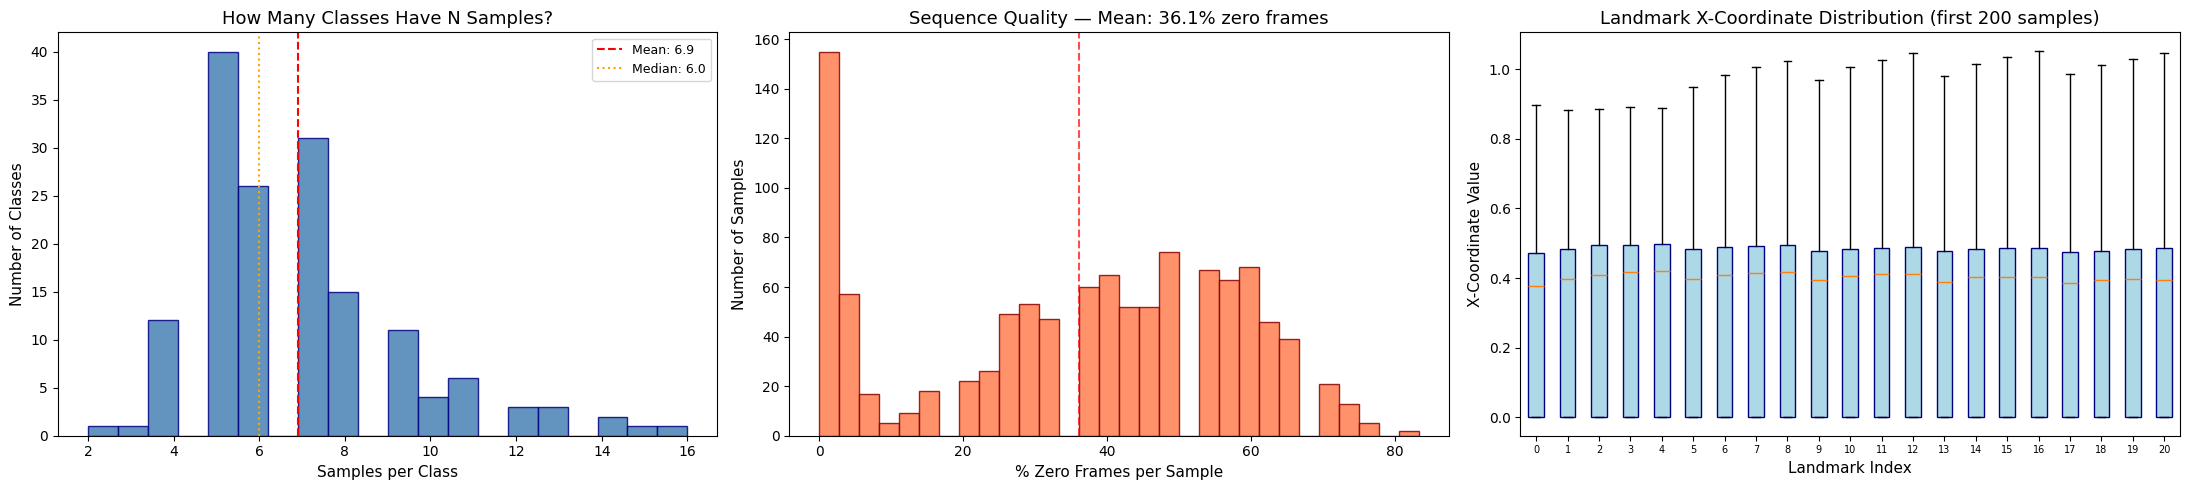


🔍 Quality Stats:
   Samples with >50% zero frames: 324 (29.9%)
   Samples with 0% zero frames  : 155 (14.3%)


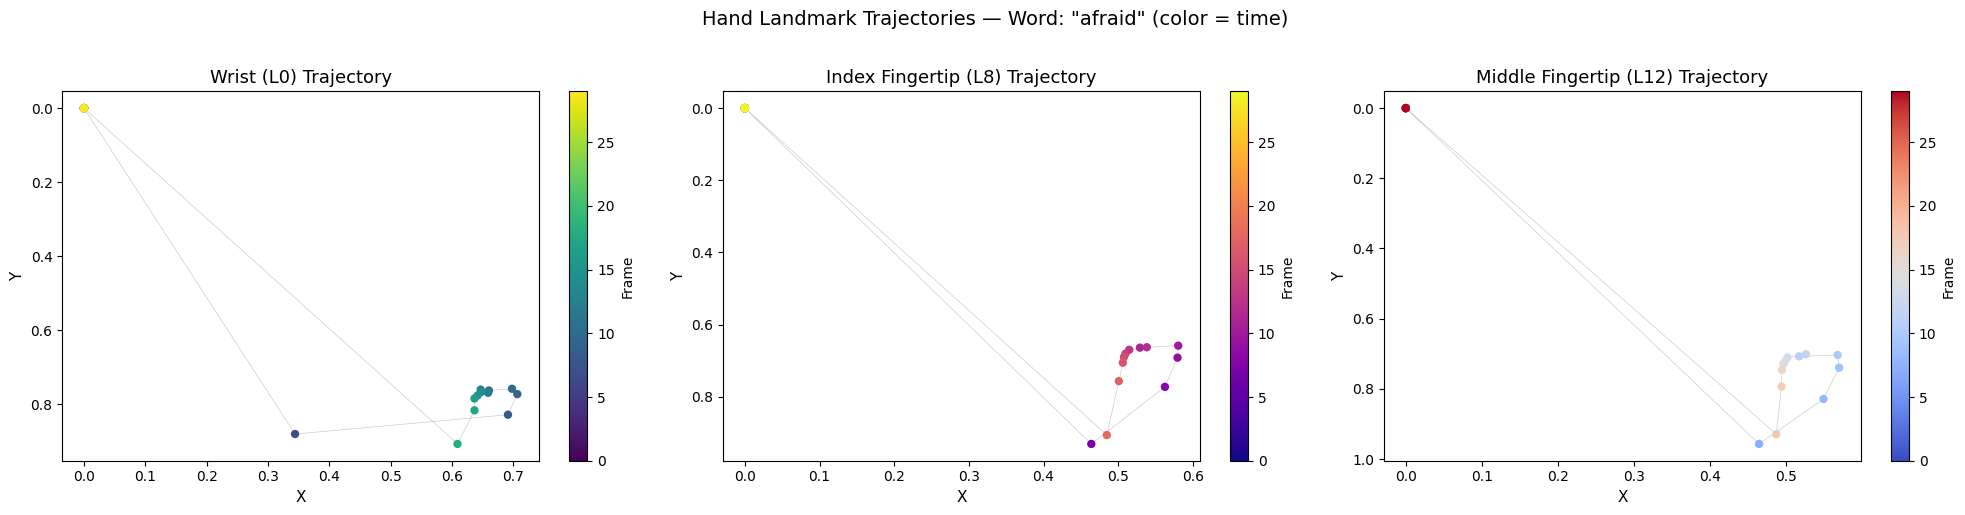

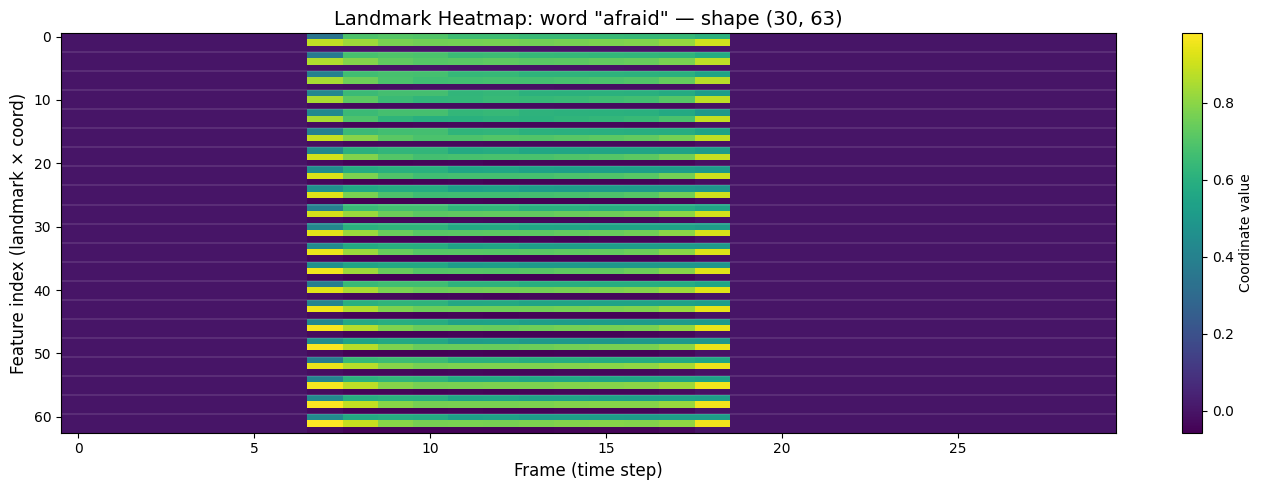

In [ ]:
# ============================================
# Section 7: Data Exploration
# ============================================
print('=' * 60)
print('📊 DATA EXPLORATION')
print('=' * 60)

# Map word_ids back to English names using vocab
id_to_english = dict(zip(vocab_df['word_id'].astype(int), vocab_df['english']))

unique_ids, counts = np.unique(y, return_counts=True)
word_names = [id_to_english.get(int(uid), str(uid)) for uid in unique_ids]

# Sort by count descending
sort_idx = np.argsort(counts)[::-1]
sorted_names  = [word_names[i] for i in sort_idx]
sorted_counts = counts[sort_idx]

# =============================================
# PLOT 1: Class distribution bar chart
# =============================================
fig, ax = plt.subplots(figsize=(24, 7))
bars = ax.bar(range(len(sorted_names)), sorted_counts, color='steelblue', edgecolor='navy', linewidth=0.3)
ax.set_xticks(range(len(sorted_names)))
ax.set_xticklabels(sorted_names, rotation=90, fontsize=6)
ax.set_xlabel('Word (Sign)', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title(f'ASL Word Dataset Distribution — {len(unique_ids)} classes, {len(y)} total samples', fontsize=14)
ax.axhline(y=np.mean(sorted_counts), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(sorted_counts):.1f}')
ax.axhline(y=np.median(sorted_counts), color='orange', linestyle=':', alpha=0.7, label=f'Median: {np.median(sorted_counts):.1f}')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Summary statistics
print(f'\n📊 Dataset Summary:')
print(f'   Total samples    : {len(y)}')
print(f'   Total classes    : {len(unique_ids)}')
print(f'   Min samples/class: {counts.min()} ({word_names[counts.argmin()]})')
print(f'   Max samples/class: {counts.max()} ({word_names[counts.argmax()]})')
print(f'   Mean             : {counts.mean():.1f}')
print(f'   Std              : {counts.std():.1f}')
print(f'   Median           : {np.median(counts):.1f}')

# Show classes with very few samples (may hurt accuracy)
low_sample = [(word_names[i], counts[i]) for i in range(len(counts)) if counts[i] < 5]
if low_sample:
    print(f'\n⚠️  Classes with <5 samples ({len(low_sample)}):')
    for name, cnt in low_sample:
        print(f'   {name}: {cnt}')

# =============================================
# PLOT 2: Class frequency histogram + Zero-frame quality + Feature distribution
# =============================================
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

# 2a: Histogram of samples-per-class
axes[0].hist(sorted_counts, bins=20, color='steelblue', edgecolor='navy', alpha=0.85)
axes[0].set_xlabel('Samples per Class', fontsize=11)
axes[0].set_ylabel('Number of Classes', fontsize=11)
axes[0].set_title('How Many Classes Have N Samples?', fontsize=13)
axes[0].axvline(x=np.mean(sorted_counts), color='red', linestyle='--', label=f'Mean: {np.mean(sorted_counts):.1f}')
axes[0].axvline(x=np.median(sorted_counts), color='orange', linestyle=':', label=f'Median: {np.median(sorted_counts):.1f}')
axes[0].legend(fontsize=9)

# 2b: Zero-frame quality analysis
zero_ratios = []
for i in range(len(X)):
    frame_sums = np.sum(np.abs(X[i]), axis=1)
    zero_frames = np.sum(frame_sums == 0)
    zero_ratios.append(zero_frames / SEQUENCE_LENGTH * 100)
zero_ratios = np.array(zero_ratios)

axes[1].hist(zero_ratios, bins=30, color='coral', edgecolor='darkred', alpha=0.85)
axes[1].set_xlabel('% Zero Frames per Sample', fontsize=11)
axes[1].set_ylabel('Number of Samples', fontsize=11)
axes[1].set_title(f'Sequence Quality — Mean: {np.mean(zero_ratios):.1f}% zero frames', fontsize=13)
axes[1].axvline(x=np.mean(zero_ratios), color='red', linestyle='--', alpha=0.7)

# 2c: Feature value distribution (boxplot of x-coordinates per landmark)
subsample = X[:min(200, len(X))].reshape(-1, NUM_FEATURES)
landmark_x = [subsample[:, i*3] for i in range(21)]
bp = axes[2].boxplot(landmark_x, whis=1.5, showfliers=False, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', edgecolor='navy'))
axes[2].set_xlabel('Landmark Index', fontsize=11)
axes[2].set_ylabel('X-Coordinate Value', fontsize=11)
axes[2].set_title('Landmark X-Coordinate Distribution (first 200 samples)', fontsize=13)
axes[2].set_xticklabels([f'{i}' for i in range(21)], fontsize=7)

plt.tight_layout()
plt.show()

print(f'\n🔍 Quality Stats:')
print(f'   Samples with >50% zero frames: {np.sum(zero_ratios > 50)} ({np.sum(zero_ratios > 50)/len(zero_ratios)*100:.1f}%)')
print(f'   Samples with 0% zero frames  : {np.sum(zero_ratios == 0)} ({np.sum(zero_ratios == 0)/len(zero_ratios)*100:.1f}%)')

# =============================================
# PLOT 3: 2D Hand Landmark Trajectories
# =============================================
sample_idx = 0
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sample = X[sample_idx]
colors = np.arange(SEQUENCE_LENGTH)

# Wrist trajectory (landmark 0)
sc0 = axes[0].scatter(sample[:, 0], sample[:, 1], c=colors, cmap='viridis', s=25, zorder=2)
axes[0].plot(sample[:, 0], sample[:, 1], 'k-', alpha=0.2, linewidth=0.5, zorder=1)
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title(f'Wrist (L0) Trajectory', fontsize=13)
axes[0].invert_yaxis()
plt.colorbar(sc0, ax=axes[0], label='Frame')

# Index fingertip trajectory (landmark 8: index 24,25)
sc1 = axes[1].scatter(sample[:, 24], sample[:, 25], c=colors, cmap='plasma', s=25, zorder=2)
axes[1].plot(sample[:, 24], sample[:, 25], 'k-', alpha=0.2, linewidth=0.5, zorder=1)
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title(f'Index Fingertip (L8) Trajectory', fontsize=13)
axes[1].invert_yaxis()
plt.colorbar(sc1, ax=axes[1], label='Frame')

# Middle fingertip trajectory (landmark 12: index 36,37)
sc2 = axes[2].scatter(sample[:, 36], sample[:, 37], c=colors, cmap='coolwarm', s=25, zorder=2)
axes[2].plot(sample[:, 36], sample[:, 37], 'k-', alpha=0.2, linewidth=0.5, zorder=1)
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title(f'Middle Fingertip (L12) Trajectory', fontsize=13)
axes[2].invert_yaxis()
plt.colorbar(sc2, ax=axes[2], label='Frame')

plt.suptitle(f'Hand Landmark Trajectories — Word: "{id_to_english.get(int(y[sample_idx]), "?")}" (color = time)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 4: Landmark Heatmap of sample sequence
# =============================================
plt.figure(figsize=(14, 5))
plt.imshow(X[sample_idx].T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Coordinate value')
plt.xlabel('Frame (time step)', fontsize=12)
plt.ylabel('Feature index (landmark × coord)', fontsize=12)
plt.title(f'Landmark Heatmap: word "{id_to_english.get(int(y[sample_idx]), "?")}" — shape {X[sample_idx].shape}', fontsize=14)

# Add landmark boundary lines
for lm in range(1, 21):
    plt.axhline(y=lm*3 - 0.5, color='white', linewidth=0.3, alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# CELL 7: PREPARE DATA SPLITS + tf.data PIPELINE
# ===============================
# Split: 60% train, 20% validation, 20% test (stratified)
# tf.data pipeline: shuffles, batches, and prefetches data efficiently for GPU

# ---> FIX: Define BATCH_SIZE explicitly here <---
BATCH_SIZE = 32

data = np.load(OUTPUT_DIR / 'asl_word_sequences.npz')
X, y = data['X'], data['y']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

# Try to stratify the first split
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_onehot, test_size=0.4, random_state=42, stratify=y_encoded
    )
except ValueError:
    print("⚠️ Warning: Some classes have only 1 sample total. Falling back to unstratified first split.")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y_onehot, test_size=0.4, random_state=42
    )

# Unstratified second split to avoid crashing on classes with only 1 sample
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Cast to float32 for consistency
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print(f'📊 Train: {X_train.shape}')
print(f'📊 Val:   {X_val.shape}')
print(f'📊 Test:  {X_test.shape}')
print(f'🏷️ Classes: {num_classes}')

# ---- tf.data pipeline (GPU-optimized) ----
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(features, labels, batch_size, training=True):
    """Create an efficient tf.data pipeline."""
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if training:
        buffer = min(len(features), 10000)
        ds = ds.shuffle(buffer_size=buffer, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, BATCH_SIZE, training=True)
val_ds = make_dataset(X_val, y_val, BATCH_SIZE, training=False)
test_ds = make_dataset(X_test, y_test, BATCH_SIZE, training=False)

print(f'\n✅ tf.data pipelines ready (batch={BATCH_SIZE})')
try:
    print(f'   {"🚀 GPU-accelerated" if USE_GPU else "🐢 CPU mode"}')
except NameError:
    pass


📊 Train / تدريب: (651, 30, 63)
📊 Val / تحقق:   (217, 30, 63)
📊 Test / اختبار: (217, 30, 63)
🏷️ Classes / فئات: 157

✅ tf.data pipelines ready (batch=32) / خطوط أنابيب البيانات جاهزة
   🚀 GPU-accelerated


In [ ]:
# ============================================
# Section 9: Build & Train BiLSTM (GPU-Optimized)
# ============================================
from sklearn.utils import class_weight
import numpy as np
import time

print('=' * 60)
print('🚀 BUILDING & TRAINING OPTIMIZED BiLSTM MODEL')
print('=' * 60)

# --- Hyperparameters (Optimized) ---
LSTM_UNITS_1   = 192      # more capacity for 157 classes
LSTM_UNITS_2   = 128
LSTM_UNITS_3   = 64       # third temporal layer
DENSE_UNITS    = 128
DROPOUT_RATE   = 0.4      # stronger regularization
LEARNING_RATE  = 5e-4     # slower, more stable convergence
EPOCHS         = 120      # more time to learn
LABEL_SMOOTH   = 0.1      # label smoothing for better generalization
GRAD_CLIP_NORM = 1.0      # gradient clipping for stability

# Clear previous session
tf.keras.backend.clear_session()

BATCH_SIZE_TRAIN = 64 if USE_GPU else BATCH_SIZE
print(f'   📦 Batch size: {BATCH_SIZE_TRAIN} ({"GPU" if USE_GPU else "CPU"})')

# --- Data Augmentation Functions ---
def augment_sequence(x, y):
    """Apply random augmentations to landmark sequences for better generalization."""
    # 1) Gaussian noise on coordinates
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.005)
    x = x + noise

    # 2) Random temporal shift: roll frames by +/-3
    shift = tf.random.uniform([], minval=-3, maxval=4, dtype=tf.int32)
    x = tf.roll(x, shift=shift, axis=0)

    # 3) Random frame dropout: zero out ~10% of frames
    frame_mask = tf.random.uniform([SEQUENCE_LENGTH, 1]) > 0.1
    frame_mask = tf.cast(frame_mask, tf.float32)
    x = x * frame_mask

    # 4) Random scaling (simulate distance variation)
    scale = tf.random.uniform([], 0.9, 1.1)
    x = x * scale

    return x, y

# --- tf.data Pipelines with Augmentation ---
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=min(len(X_train), 10000), seed=42, reshuffle_each_iteration=True)
train_ds = train_ds.map(augment_sequence, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE_TRAIN).prefetch(AUTOTUNE)

print(f'   ✅ tf.data pipelines with augmentation ready')

# --- Class Weights ---
y_train_int = np.argmax(y_train, axis=1)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_array = np.clip(class_weights_array, 0.5, 10.0)
class_weights = dict(enumerate(class_weights_array))
print(f'   ⚖️ Class weights calculated for {len(class_weights)} classes (clipped to [0.5, 10])')

# --- Temporal Attention Layer ---
class TemporalAttention(tf.keras.layers.Layer):
    """Learnable attention over time steps — lets the model focus on key frames."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output

# --- Build Optimized Model ---
with tf.device(DEVICE):
    model = Sequential([
        Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name='landmark_sequence'),

        # BiLSTM block 1 — captures broad temporal patterns
        Bidirectional(LSTM(LSTM_UNITS_1, return_sequences=True,
                           recurrent_dropout=0.0,
                           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
                      name='bilstm_1'),
        BatchNormalization(name='bn_1'),
        tf.keras.layers.SpatialDropout1D(DROPOUT_RATE, name='sdrop_1'),

        # BiLSTM block 2 — refines temporal features
        Bidirectional(LSTM(LSTM_UNITS_2, return_sequences=True,
                           kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
                      name='bilstm_2'),
        BatchNormalization(name='bn_2'),
        tf.keras.layers.SpatialDropout1D(DROPOUT_RATE, name='sdrop_2'),

        # LSTM block 3 — final temporal encoding
        LSTM(LSTM_UNITS_3, return_sequences=True,
             kernel_regularizer=tf.keras.regularizers.l2(1e-4),
             name='lstm_3'),
        BatchNormalization(name='bn_3'),

        # Temporal Attention — focus on discriminative frames
        TemporalAttention(name='temporal_attention'),
        Dropout(DROPOUT_RATE, name='drop_att'),

        # Dense classifier head
        Dense(DENSE_UNITS, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4),
              name='dense_1'),
        BatchNormalization(name='bn_dense'),
        Dropout(DROPOUT_RATE, name='drop_dense'),

        Dense(DENSE_UNITS // 2, activation='relu',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4),
              name='dense_2'),
        Dropout(DROPOUT_RATE * 0.5, name='drop_dense_2'),

        Dense(num_classes, activation='softmax', dtype='float32', name='output')
    ], name='ASL_Word_BiLSTM_v2')

# --- Optimizer with gradient clipping ---
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    clipnorm=GRAD_CLIP_NORM
)

# --- Loss with label smoothing ---
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

print('\n📐 Model Architecture:')
model.summary()
print(f'\n🖥️  Training on: {DEVICE}')

# --- Callbacks ---
callbacks = [
    ModelCheckpoint(
        str(OUTPUT_DIR / 'asl_word_lstm_model_best.h5'),
        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.TerminateOnNaN()
]

# --- Train ---
print('\n🚀 Starting training...')
start_time = time.time()

with tf.device(DEVICE):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

training_time = time.time() - start_time
print(f'\n✅ Training complete in {training_time:.1f}s ({training_time/60:.1f} min)')

# Save final model + class mapping
model.save(str(OUTPUT_DIR / 'asl_word_lstm_model_final.h5'))
class_df = pd.DataFrame({
    'model_class_index': range(num_classes),
    'word_id': encoder.classes_.tolist()
})
class_df.to_csv(OUTPUT_DIR / 'asl_word_classes.csv', index=False)
print(f'\n💾 Final model : {OUTPUT_DIR / "asl_word_lstm_model_final.h5"}')
print(f'💾 Best model  : {OUTPUT_DIR / "asl_word_lstm_model_best.h5"}')
print(f'💾 Classes CSV : {OUTPUT_DIR / "asl_word_classes.csv"}')


🚀 BUILDING & TRAINING BiLSTM MODEL
   📦 Batch size (auto): 64 (GPU)
   ✅ tf.data pipelines created (shuffle + batch + prefetch)
   ⚖️ Class weights calculated for 157 classes

📐 Model Architecture:
Model: "ASL_Word_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bilstm_1 (Bidirectional)    (None, 30, 256)           196608    
                                                                 
 bn_1 (BatchNormalization)   (None, 30, 256)           1024      
                                                                 
 drop_1 (Dropout)            (None, 30, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                82176     
                                                                 
 bn_2 (BatchNormalization)   (None, 64)                256       
                                                   

📈 MODEL EVALUATION & VISUALIZATION DASHBOARD

🎯 Test Results:
   Top-1 Accuracy : 0.0092 (0.92%)
   Top-5 Accuracy : 0.0461 (4.61%)
   Test samples   : 217
   Classes         : 157


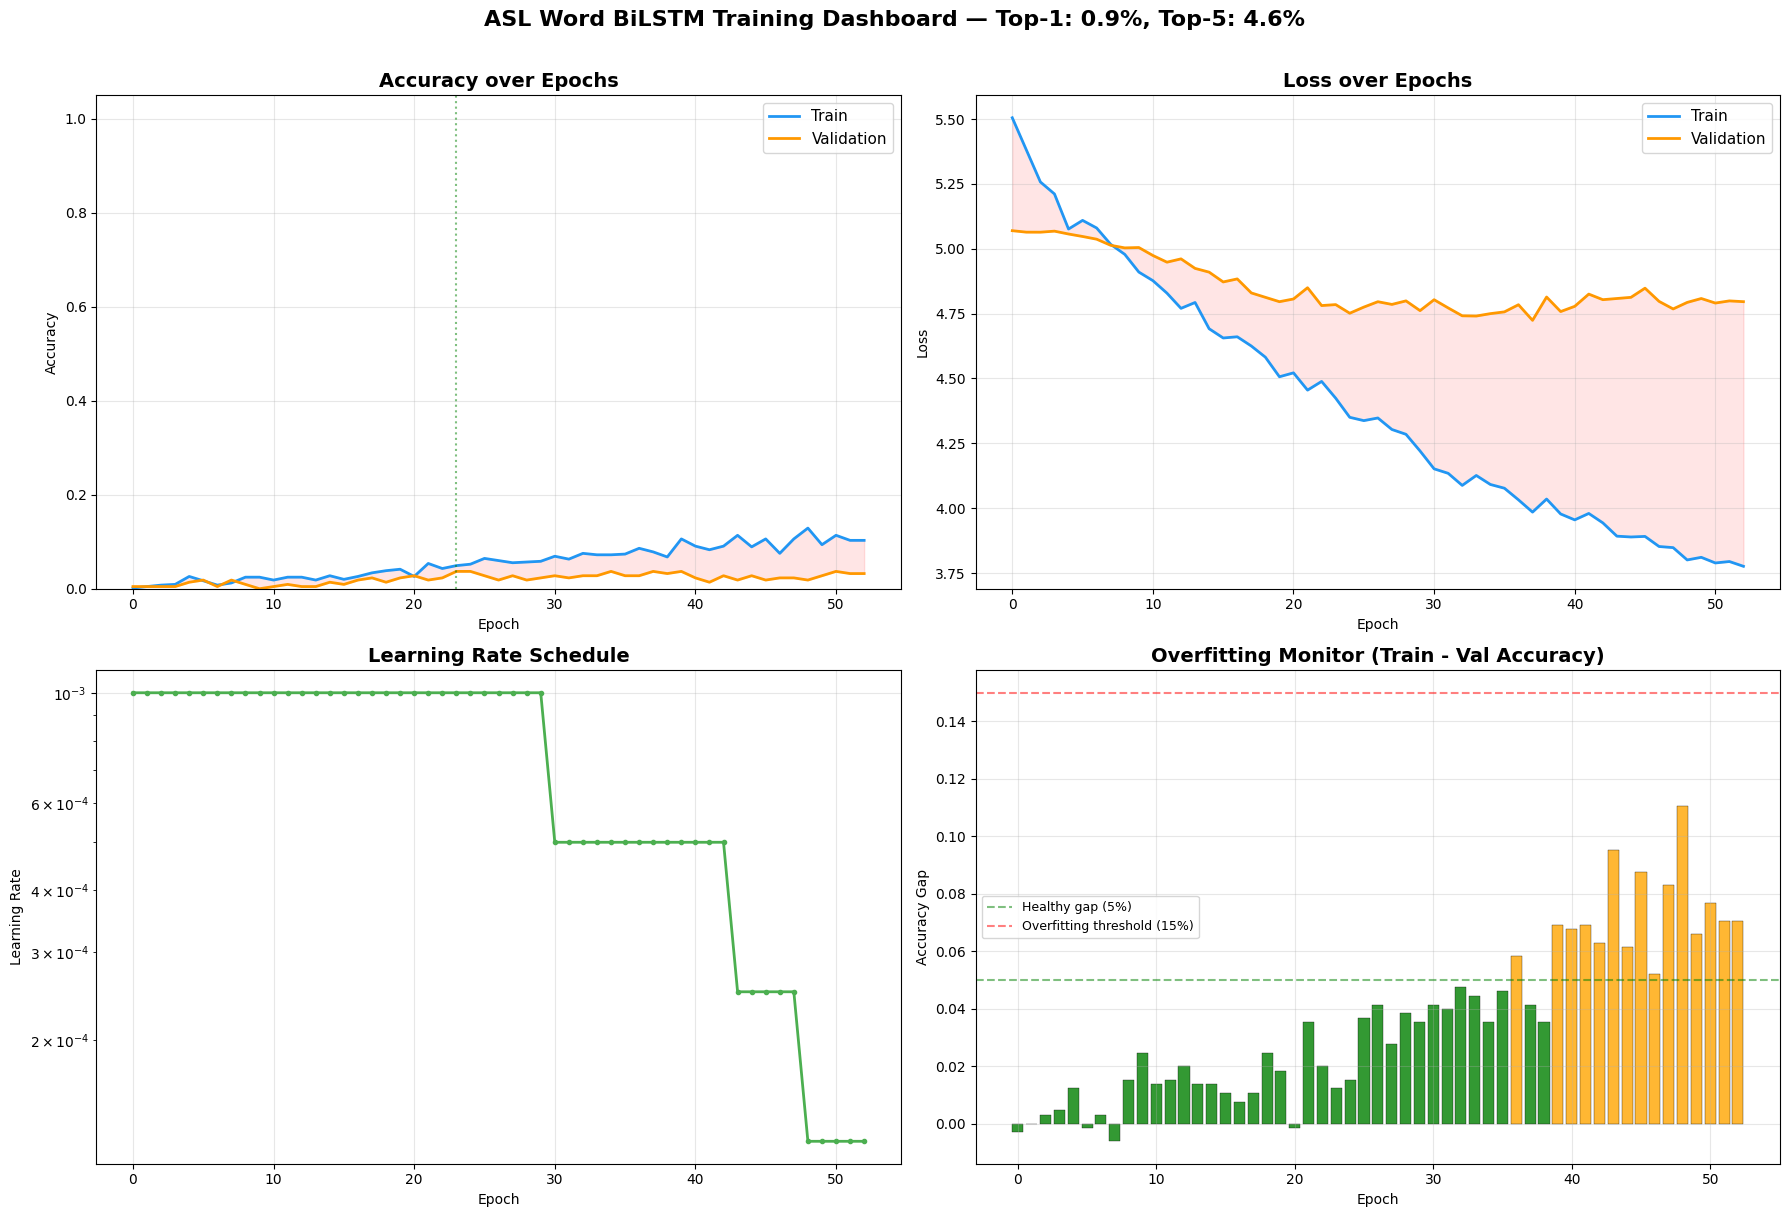

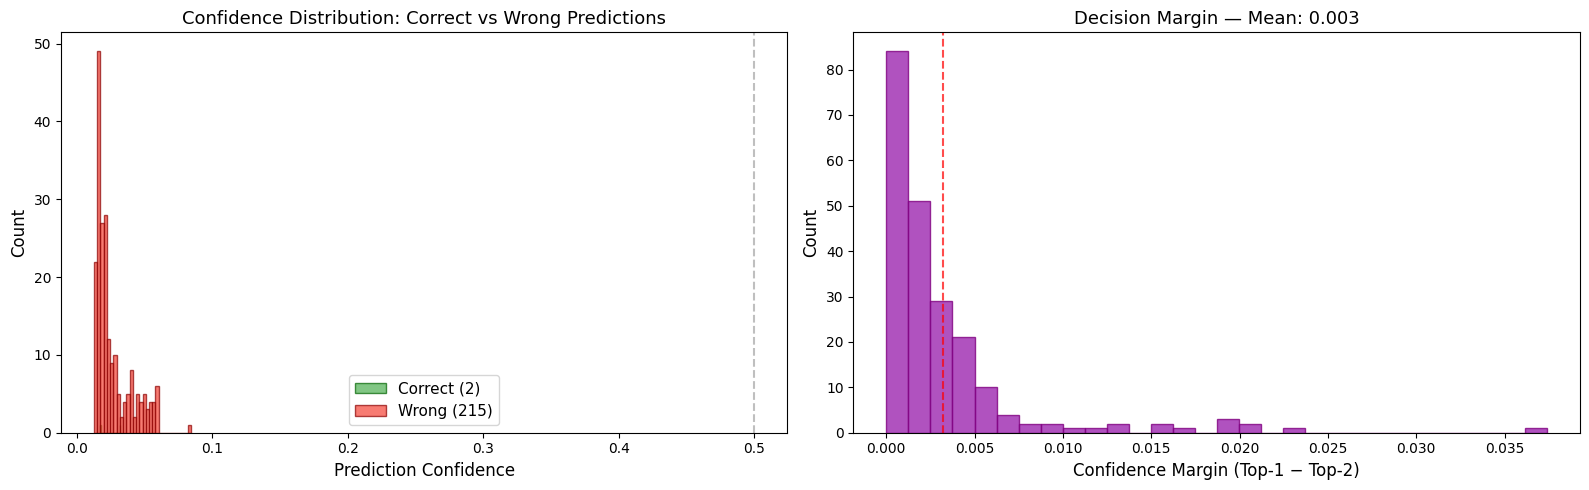


📋 Classification Report:
              precision    recall  f1-score   support

       drink       0.00      0.00      0.00         3
       chair       0.00      0.00      0.00         1
        help       0.00      0.00      0.00         2
        thin       0.00      0.00      0.00         3
        walk       0.00      0.00      0.00         2
      mother       0.00      0.00      0.00         1
       table       0.00      0.00      0.00         1
         bed       0.00      0.00      0.00         4
      family       0.00      0.00      0.00         3
         man       0.00      0.00      0.00         1
        tall       0.00      0.00      0.00         4
      doctor       0.00      0.00      0.00         2
         eat       0.00      0.00      0.00         2
       short       0.00      0.00      0.00         5
    medicine       0.00      0.00      0.00         2
       right       0.00      0.00      0.00         2
         son       0.00      0.00      0.00         2
 

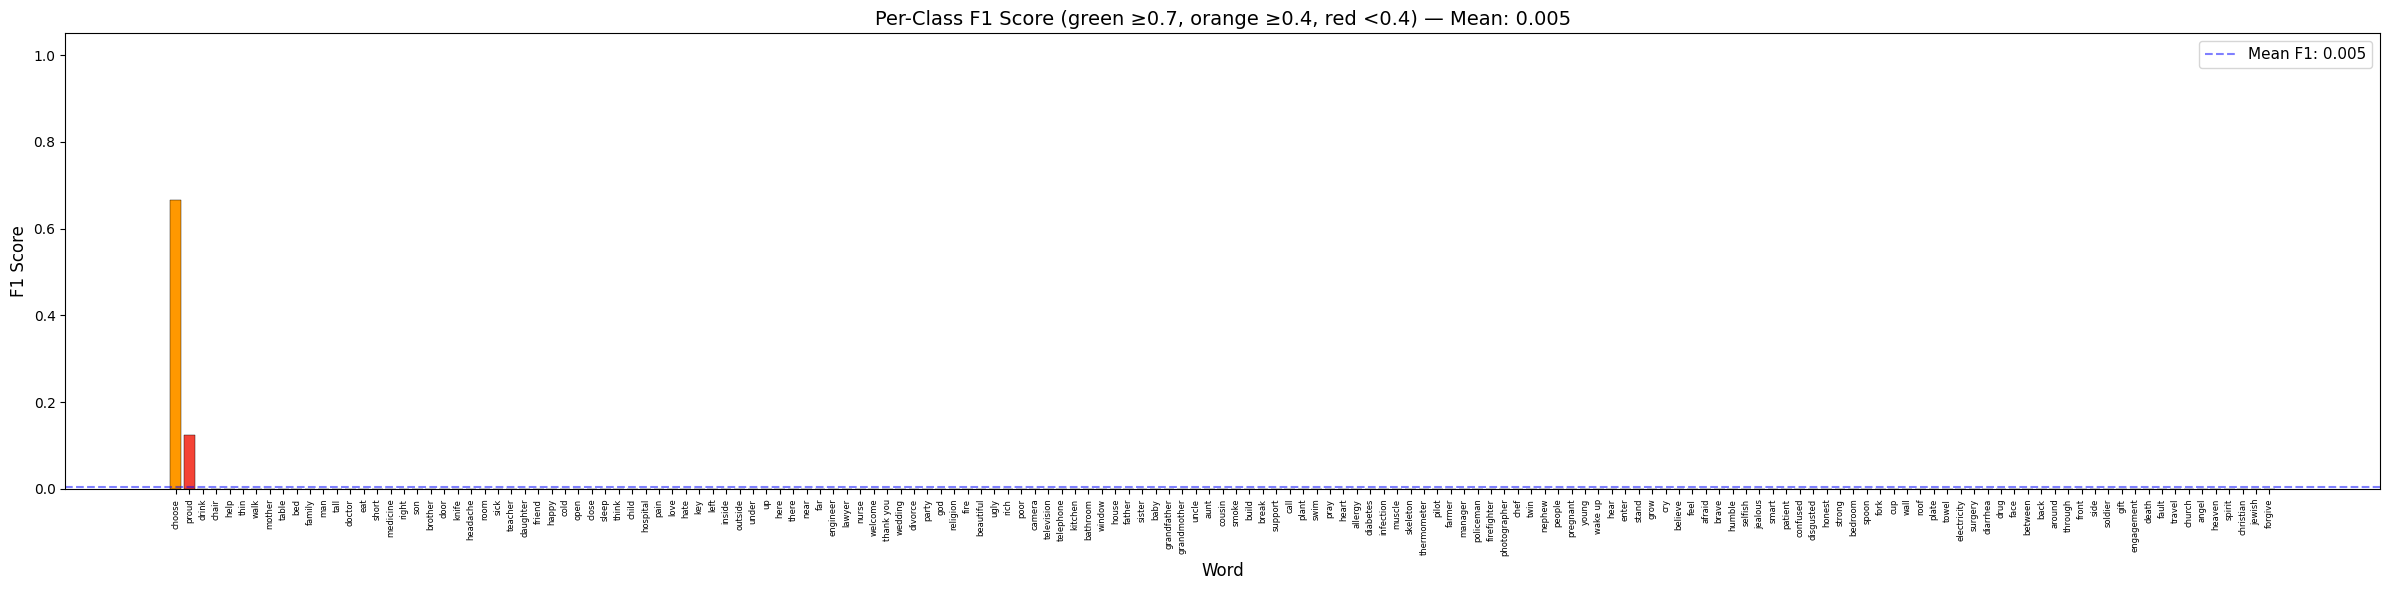

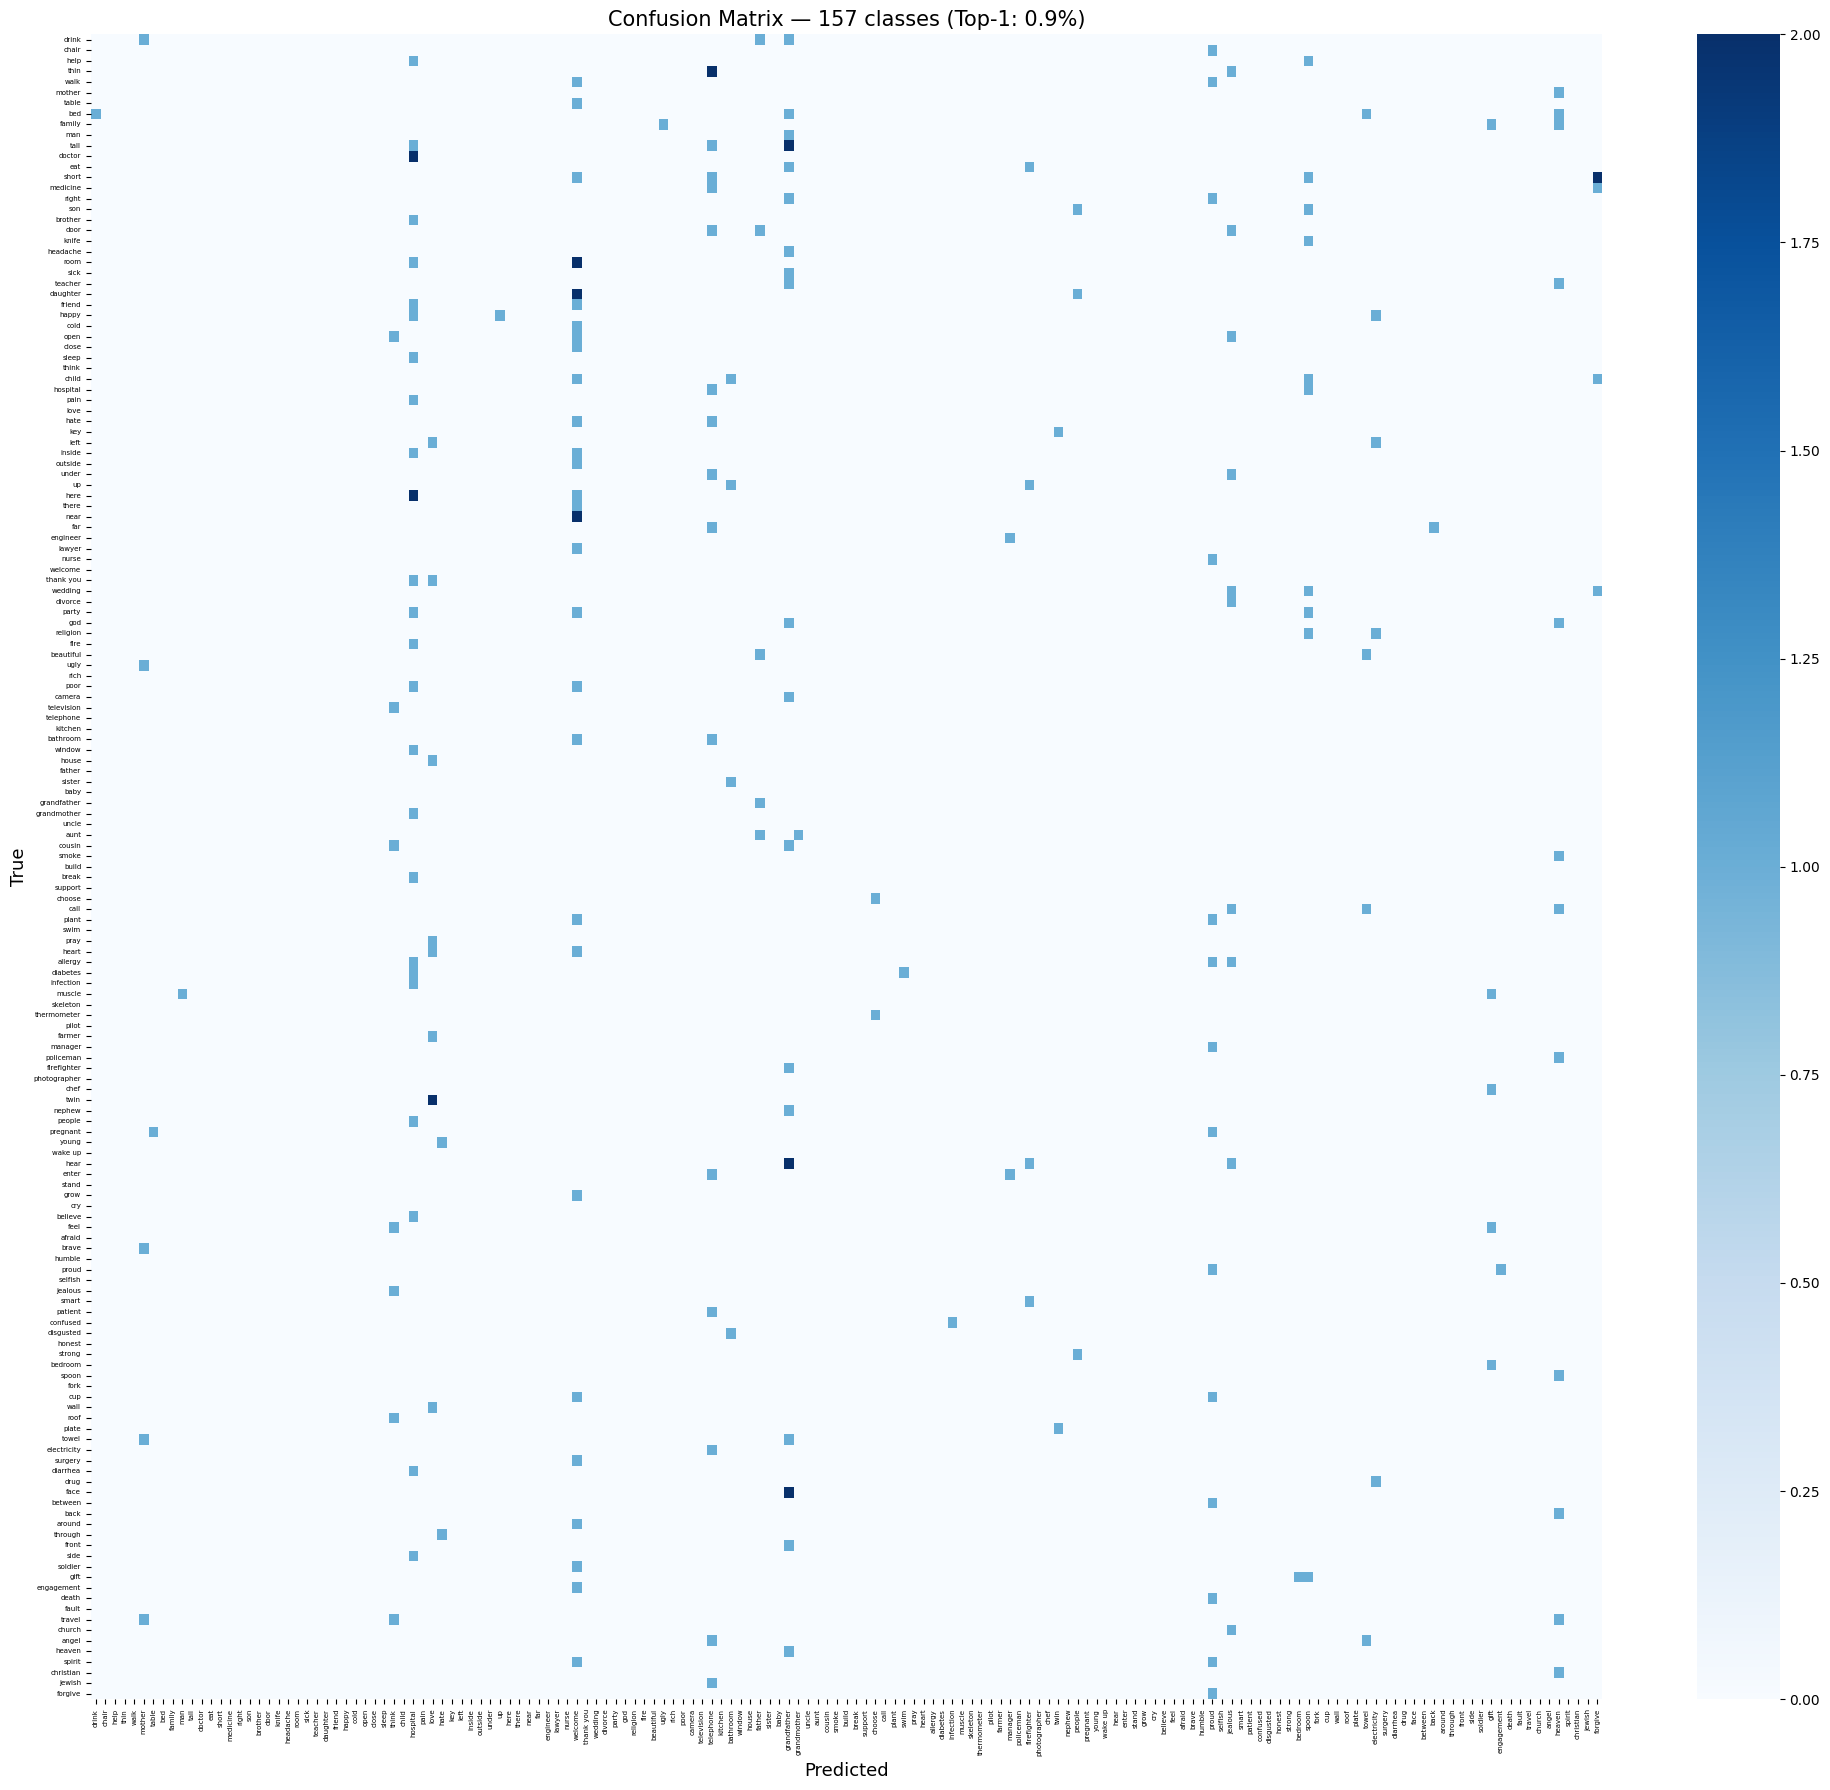

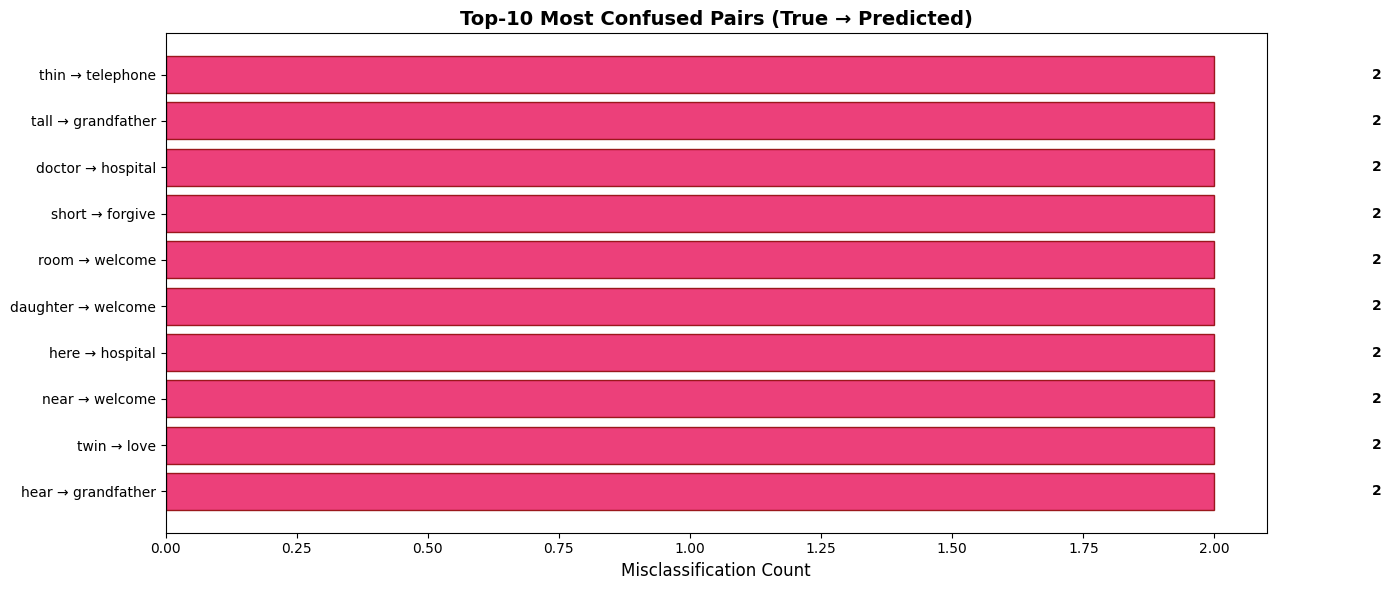

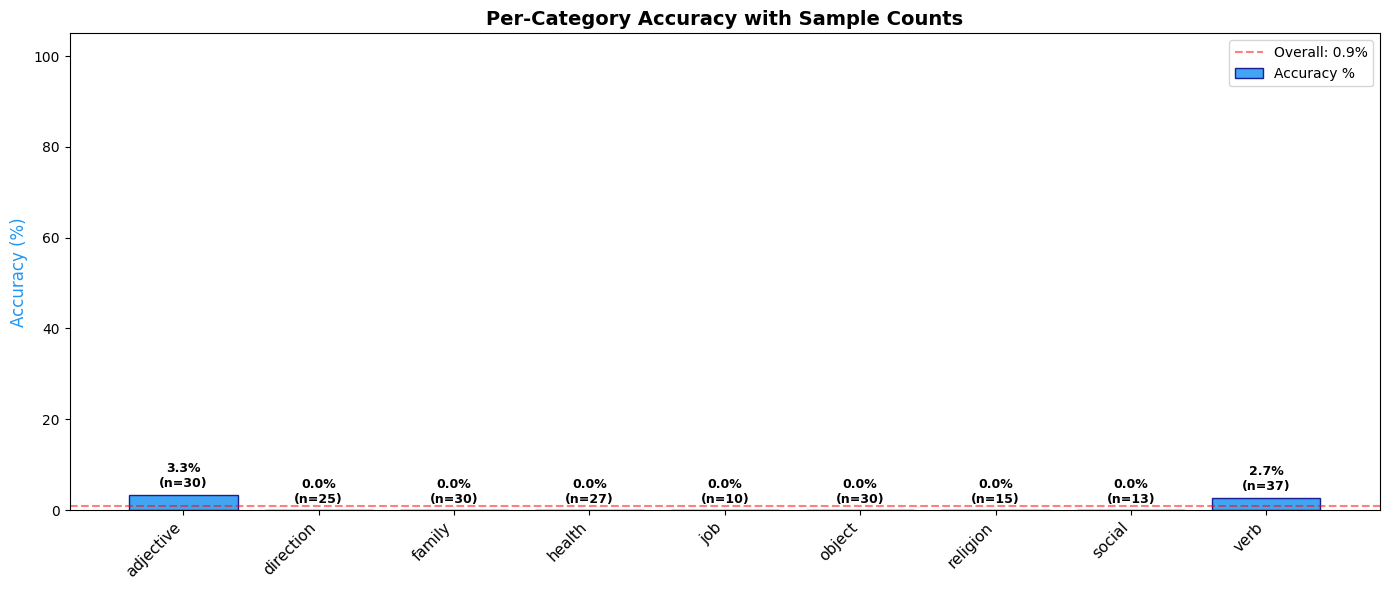

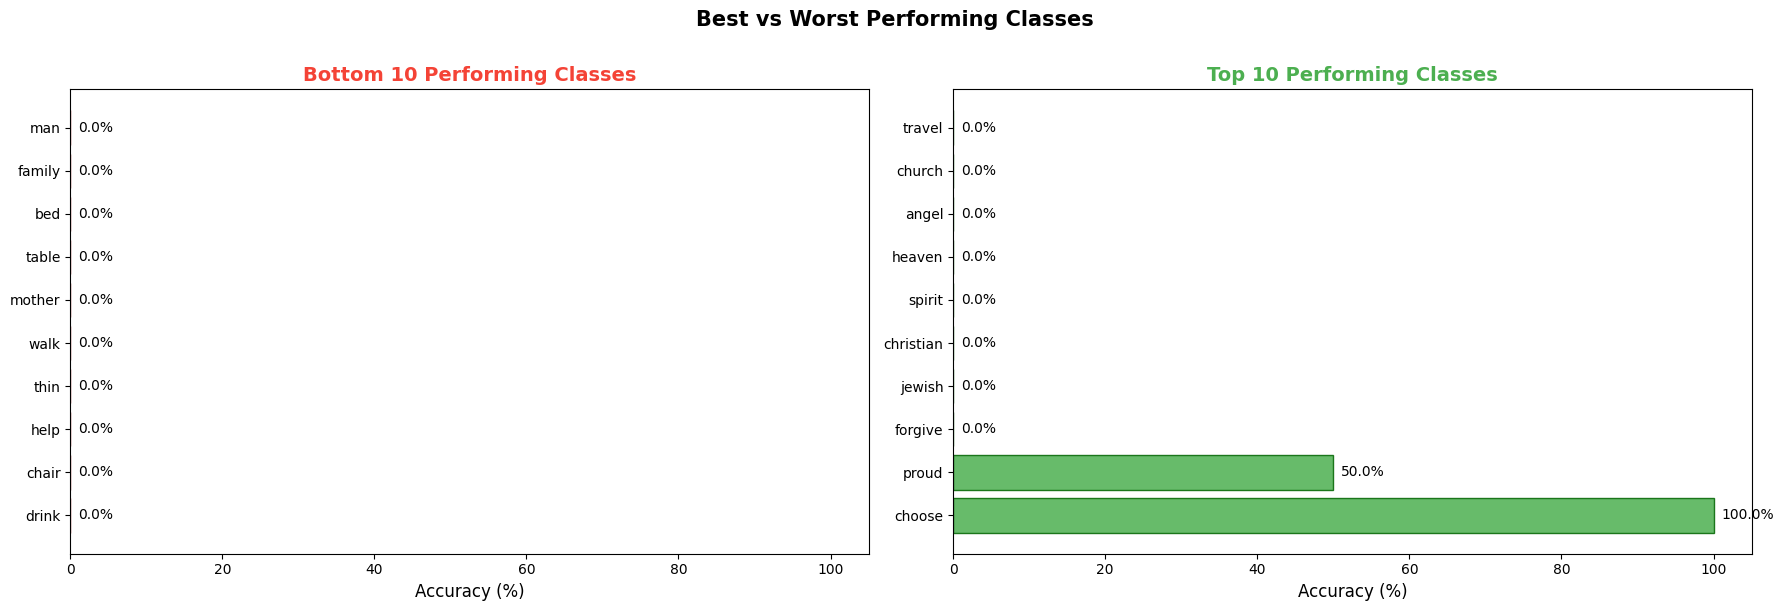

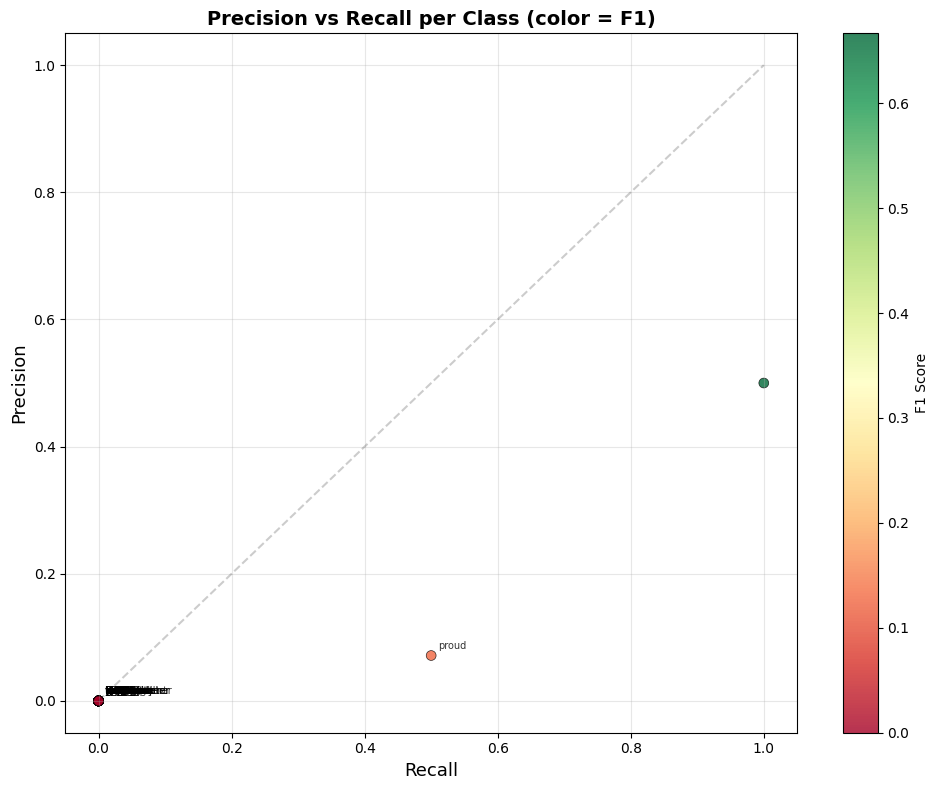


✅ Evaluation & Visualization Dashboard complete!


In [ ]:
# ============================================
# Section 10: Evaluation & Visualization Dashboard
# ============================================
print('=' * 60)
print('📈 MODEL EVALUATION & VISUALIZATION DASHBOARD')
print('=' * 60)

# Load best checkpoint (with custom TemporalAttention layer)
best_model = tf.keras.models.load_model(
    str(OUTPUT_DIR / 'asl_word_lstm_model_best.h5'),
    custom_objects={'TemporalAttention': TemporalAttention}
)

# Predict using test dataset pipeline
eval_batch = 64 if USE_GPU else 32
eval_ds = tf.data.Dataset.from_tensor_slices((X_test,)).batch(eval_batch).prefetch(tf.data.AUTOTUNE)

with tf.device(DEVICE):
    proba = best_model.predict(eval_ds, verbose=0)

y_pred = np.argmax(proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Top-1 accuracy
top1_acc = (y_pred == y_true).mean()

# Top-5 accuracy
top5_correct = 0
for i in range(len(y_true)):
    top5 = np.argsort(proba[i])[-5:]
    if y_true[i] in top5:
        top5_correct += 1
top5_acc = top5_correct / len(y_true)

print(f'\n🎯 Test Results:')
print(f'   Top-1 Accuracy : {top1_acc:.4f} ({top1_acc*100:.2f}%)')
print(f'   Top-5 Accuracy : {top5_acc:.4f} ({top5_acc*100:.2f}%)')
print(f'   Test samples   : {len(y_true)}')
print(f'   Classes         : {num_classes}')

# =============================================
# PLOT 1: Training Dashboard (4 panels)
# =============================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1a: Accuracy curves
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2, color='#2196F3')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#FF9800')
axes[0, 0].fill_between(range(len(history.history['accuracy'])),
                         history.history['accuracy'], history.history['val_accuracy'],
                         alpha=0.1, color='red')
axes[0, 0].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])
best_epoch = np.argmax(history.history['val_accuracy'])
axes[0, 0].axvline(x=best_epoch, color='green', linestyle=':', alpha=0.5, label=f'Best: epoch {best_epoch}')

# 1b: Loss curves
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2, color='#2196F3')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='#FF9800')
axes[0, 1].fill_between(range(len(history.history['loss'])),
                         history.history['loss'], history.history['val_loss'],
                         alpha=0.1, color='red')
axes[0, 1].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 1c: Learning Rate schedule
if 'lr' in history.history:
    lr_values = history.history['lr']
else:
    lr_values = [LEARNING_RATE] * len(history.history['loss'])
axes[1, 0].plot(lr_values, linewidth=2, color='#4CAF50', marker='o', markersize=3)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 1d: Overfitting gap (train_acc - val_acc)
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
gap = train_acc - val_acc
axes[1, 1].bar(range(len(gap)), gap, color=['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gap],
               edgecolor='black', linewidth=0.3, alpha=0.8)
axes[1, 1].axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Healthy gap (5%)')
axes[1, 1].axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='Overfitting threshold (15%)')
axes[1, 1].set_title('Overfitting Monitor (Train - Val Accuracy)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'ASL Word BiLSTM Training Dashboard — Top-1: {top1_acc*100:.1f}%, Top-5: {top5_acc*100:.1f}%',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 2: Prediction Confidence Distribution
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

correct_mask = y_pred == y_true
correct_conf = np.max(proba[correct_mask], axis=1)
wrong_conf   = np.max(proba[~correct_mask], axis=1) if np.sum(~correct_mask) > 0 else np.array([])

axes[0].hist(correct_conf, bins=30, alpha=0.7, color='#4CAF50', edgecolor='darkgreen', label=f'Correct ({len(correct_conf)})')
if len(wrong_conf) > 0:
    axes[0].hist(wrong_conf, bins=30, alpha=0.7, color='#F44336', edgecolor='darkred', label=f'Wrong ({len(wrong_conf)})')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Confidence Distribution: Correct vs Wrong Predictions', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Confidence by rank (top-1 vs top-2 gap)
top1_conf = np.max(proba, axis=1)
sorted_proba = np.sort(proba, axis=1)[:, ::-1]
top2_conf = sorted_proba[:, 1] if proba.shape[1] > 1 else np.zeros(len(proba))
margin = top1_conf - top2_conf

axes[1].hist(margin, bins=30, color='#9C27B0', edgecolor='purple', alpha=0.8)
axes[1].set_xlabel('Confidence Margin (Top-1 - Top-2)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title(f'Decision Margin — Mean: {np.mean(margin):.3f}', fontsize=13)
axes[1].axvline(x=np.mean(margin), color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# =============================================
# PLOT 3: Classification Report
# =============================================
word_labels = []
for cls_idx in range(num_classes):
    wid = int(encoder.classes_[cls_idx])
    word_labels.append(id_to_english.get(wid, str(wid)))

print('\n📋 Classification Report:')
report = classification_report(y_true, y_pred, labels=range(num_classes), target_names=word_labels, zero_division=0, output_dict=True)
print(classification_report(y_true, y_pred, labels=range(num_classes), target_names=word_labels, zero_division=0))

# =============================================
# PLOT 4: Per-Class F1 Score Bar Chart
# =============================================
class_f1 = {k: v['f1-score'] for k, v in report.items() if k in word_labels}
sorted_f1 = sorted(class_f1.items(), key=lambda x: x[1], reverse=True)
f1_names = [x[0] for x in sorted_f1]
f1_vals  = [x[1] for x in sorted_f1]

fig, ax = plt.subplots(figsize=(24, 6))
colors_f1 = ['#4CAF50' if v >= 0.7 else '#FF9800' if v >= 0.4 else '#F44336' for v in f1_vals]
ax.bar(range(len(f1_names)), f1_vals, color=colors_f1, edgecolor='black', linewidth=0.3)
ax.set_xticks(range(len(f1_names)))
ax.set_xticklabels(f1_names, rotation=90, fontsize=6)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title(f'Per-Class F1 Score (green>=0.7, orange>=0.4, red<0.4) — Mean: {np.mean(f1_vals):.3f}', fontsize=14)
ax.axhline(y=np.mean(f1_vals), color='blue', linestyle='--', alpha=0.5, label=f'Mean F1: {np.mean(f1_vals):.3f}')
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

# =============================================
# PLOT 5: Confusion Matrix
# =============================================
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

fig, ax = plt.subplots(figsize=(20, 18))
if num_classes <= 50:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=word_labels, yticklabels=word_labels, ax=ax,
                linewidths=0.5, linecolor='lightgray')
else:
    sns.heatmap(cm, annot=False, cmap='Blues',
                xticklabels=word_labels, yticklabels=word_labels, ax=ax)
ax.set_title(f'Confusion Matrix — {num_classes} classes (Top-1: {top1_acc*100:.1f}%)', fontsize=15)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('True', fontsize=13)
plt.xticks(rotation=90, fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 6: Top-10 Most Confused Pairs
# =============================================
np.fill_diagonal(cm, 0)
confused_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if cm[i, j] > 0:
            confused_pairs.append((word_labels[i], word_labels[j], cm[i, j]))
confused_pairs.sort(key=lambda x: x[2], reverse=True)
top_confused = confused_pairs[:10]

if top_confused:
    fig, ax = plt.subplots(figsize=(14, 6))
    pair_labels = [f'{p[0]} -> {p[1]}' for p in top_confused]
    pair_counts = [p[2] for p in top_confused]
    bars = ax.barh(range(len(pair_labels)), pair_counts, color='#E91E63', edgecolor='darkred', alpha=0.85)
    ax.set_yticks(range(len(pair_labels)))
    ax.set_yticklabels(pair_labels, fontsize=10)
    ax.set_xlabel('Misclassification Count', fontsize=12)
    ax.set_title('Top-10 Most Confused Pairs (True -> Predicted)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    for bar, count in zip(bars, pair_counts):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                str(count), va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

# =============================================
# PLOT 7: Per-Category Accuracy
# =============================================
cat_map = dict(zip(vocab_df['word_id'].astype(int), vocab_df['category']))
category_correct, category_total = {}, {}
for i in range(len(y_true)):
    wid = int(encoder.classes_[y_true[i]])
    cat = cat_map.get(wid, 'unknown')
    category_total[cat] = category_total.get(cat, 0) + 1
    if y_pred[i] == y_true[i]:
        category_correct[cat] = category_correct.get(cat, 0) + 1

cat_names = sorted(category_total.keys())
cat_accs  = [category_correct.get(c, 0) / category_total[c] for c in cat_names]
cat_sizes = [category_total[c] for c in cat_names]

fig, ax1 = plt.subplots(figsize=(14, 6))

x_pos = range(len(cat_names))
bars = ax1.bar(x_pos, [a * 100 for a in cat_accs], color='#2196F3', edgecolor='navy', alpha=0.85, label='Accuracy %')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(cat_names, rotation=45, ha='right', fontsize=11)
ax1.set_ylabel('Accuracy (%)', fontsize=12, color='#2196F3')
ax1.set_ylim([0, 105])

for bar, acc, size in zip(bars, cat_accs, cat_sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc*100:.1f}%\n(n={size})', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_title('Per-Category Accuracy with Sample Counts', fontsize=14, fontweight='bold')
ax1.axhline(y=top1_acc*100, color='red', linestyle='--', alpha=0.5, label=f'Overall: {top1_acc*100:.1f}%')
ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 8: Best & Worst Performing Classes
# =============================================
per_class_acc = {}
for i in range(num_classes):
    mask = y_true == i
    if mask.sum() > 0:
        per_class_acc[word_labels[i]] = (y_pred[mask] == i).mean()

sorted_acc = sorted(per_class_acc.items(), key=lambda x: x[1])
n_show = min(10, len(sorted_acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Worst
worst = sorted_acc[:n_show]
ax1.barh(range(len(worst)), [w[1]*100 for w in worst], color='#F44336', edgecolor='darkred', alpha=0.85)
ax1.set_yticks(range(len(worst)))
ax1.set_yticklabels([w[0] for w in worst], fontsize=10)
ax1.set_xlabel('Accuracy (%)', fontsize=12)
ax1.set_title(f'Bottom {n_show} Performing Classes', fontsize=14, fontweight='bold', color='#F44336')
ax1.set_xlim([0, 105])
for i, w in enumerate(worst):
    ax1.text(w[1]*100 + 1, i, f'{w[1]*100:.1f}%', va='center', fontsize=10)

# Best
best = sorted_acc[-n_show:][::-1]
ax2.barh(range(len(best)), [b[1]*100 for b in best], color='#4CAF50', edgecolor='darkgreen', alpha=0.85)
ax2.set_yticks(range(len(best)))
ax2.set_yticklabels([b[0] for b in best], fontsize=10)
ax2.set_xlabel('Accuracy (%)', fontsize=12)
ax2.set_title(f'Top {n_show} Performing Classes', fontsize=14, fontweight='bold', color='#4CAF50')
ax2.set_xlim([0, 105])
for i, b in enumerate(best):
    ax2.text(b[1]*100 + 1, i, f'{b[1]*100:.1f}%', va='center', fontsize=10)

plt.suptitle('Best vs Worst Performing Classes', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# =============================================
# PLOT 9: Precision vs Recall Scatter
# =============================================
precisions = [report[w]['precision'] for w in word_labels if w in report]
recalls = [report[w]['recall'] for w in word_labels if w in report]
f1s = [report[w]['f1-score'] for w in word_labels if w in report]
labels_in_report = [w for w in word_labels if w in report]

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(recalls, precisions, c=f1s, cmap='RdYlGn', s=50, edgecolors='black', linewidth=0.5, alpha=0.8)
plt.colorbar(scatter, label='F1 Score', ax=ax)
ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision vs Recall per Class (color = F1)', fontsize=14, fontweight='bold')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.plot([0, 1], [0, 1], 'k--', alpha=0.2)
ax.grid(True, alpha=0.3)

for i, lbl in enumerate(labels_in_report):
    if f1s[i] < 0.3:
        ax.annotate(lbl, (recalls[i], precisions[i]), fontsize=7, alpha=0.8,
                    xytext=(5, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

print('\n' + '=' * 60)
print('✅ Evaluation & Visualization Dashboard complete!')
print('=' * 60)


## Tips & Troubleshooting

| Issue                      | Solution                                             |
| -------------------------- | ---------------------------------------------------- |
| **OOM (Out of Memory)**    | Reduce `BATCH_SIZE` to 64 or 32                      |
| **No GPU detected**        | Install `tensorflow[and-cuda]` or check CUDA/cuDNN   |
| **Slow training**          | Ensure GPU is being used (check Cell 2 output)       |
| **Low accuracy**           | Increase epochs, add more data, or tune LSTM units   |
| **Mixed precision errors** | Remove the mixed precision block in Cell 2           |
| **Download failures**      | Check internet, install yt-dlp: `pip install yt-dlp` |

### Monitor GPU:

```powershell
nvidia-smi -l 1
```

### Key Differences from Letter Training:

- Letters use **MLP** (flat keypoints per image)
- Words use **BiLSTM** (sequences of keypoints over time)
- Words need `SEQUENCE_LENGTH` frames per sample
- WLASL videos must be downloaded first (Cell 5)
